# Learn by Building: Time Series Forecasting with PyTorch

#### Irdiansyah

Pada LBB Time Series Forecasting with PyTorch ini, saya (Irdiansyah) akan menggunakan dataset [Weather Forecasting for Indian climate](https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data). Dataset ini menyediakan informasi harian terkait climate di Kota Delhi, India dari tanggal 1 Januari 2013 hingga 24 April 2017. Ada 4 parameter (kolom data) yang tersedia yaitu meantemp, humidity, wind_speed, meanpressure. Kemudian, dataset ini juga sudah dibagi menjadi data training dan data test.

## PyTorch Workflow & Implementing RNN with PyTorch

Pada PyTorch terdapat 4 langkah utama untuk mengerjakan sebuah kasus machine learning, yaitu:
- Persiapan data
- Pembuatan arsitektur
- Persiapan training
- Training loop

Training loop ini digunakan karena arsitektur yang kita bangun merupakan proses RNN 1x feed forward dan 1x backpropagation, sehingga kita perlu membuat langkah perulangan untuk melakukan training dengan epoch yang banyak.

In [1391]:
# import library dasar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Persiapan data

Seperti yang sudah dijelaskan sebelumnya dataset ini sudah dipisah menjadi data train dan data test biasa. Ada 1462 baris data di data train dan 114 baris data di data test. Dari total 1576 baris data itu 93% merupakan data train dan 7% nya dijadikan data test.

In [1392]:
# baca kembali dataset yang digunakan
train_all = pd.read_csv("delhi-climate/DailyDelhiClimateTrain.csv") #93%
test_all = pd.read_csv("delhi-climate/DailyDelhiClimateTest.csv") #7%

Dari 4 parameter yang disediakan saya akan mencoba forecasting meantemp saja, data ini akan saya pisahkan dengan cara sub setting

In [1393]:
train_df = train_all[["date", "meantemp"]]

In [1394]:
test_df = test_all[["date", "meantemp"]]

#### Cek data

Untuk memastikan data bisa digunakan, kita perlu cek tipe data, cek data yang Null, cek jumlah baris yang tersedia denga cara berikut:  

In [1395]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      1462 non-null   object 
 1   meantemp  1462 non-null   float64
dtypes: float64(1), object(1)
memory usage: 23.0+ KB


In [1396]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      114 non-null    object 
 1   meantemp  114 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.9+ KB


Dari data di atas diketahui tidak ada data yang null (kosong), kemudian tipe data "date" kurang tepat. Tipe data "date" akan diubah dari tipe data object ke datetime64.

In [1397]:
train_df["date"] = train_df["date"].astype("datetime64")

/var/folders/x_/1h27z5411yggd3zgcv_9_cmh0000gn/T/ipykernel_1089/2520553436.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["date"] = train_df["date"].astype("datetime64")


Kemudian mengubah format waktunya 

In [1398]:
train_df["date"] = pd.to_datetime(train_df["date"], format = "%m/%d/%Y")

/var/folders/x_/1h27z5411yggd3zgcv_9_cmh0000gn/T/ipykernel_1089/3338144497.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["date"] = pd.to_datetime(train_df["date"], format = "%m/%d/%Y")


In [1399]:
train_df.dtypes

date        datetime64[ns]
meantemp           float64
dtype: object

In [1400]:
test_df["date"] = test_df["date"].astype("datetime64")

/var/folders/x_/1h27z5411yggd3zgcv_9_cmh0000gn/T/ipykernel_1089/2622443765.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["date"] = test_df["date"].astype("datetime64")


In [1401]:
test_df.dtypes

date        datetime64[ns]
meantemp           float64
dtype: object

#### Cek kesinambungan data

Untuk memastikan data train dan data test tidak bersilangan. Dilakukan cek data di bagian tail dan head.

In [1402]:
train_df.tail()

,date,meantemp
1457,2016-12-28,17.217391
1458,2016-12-29,15.238095
1459,2016-12-30,14.095238
1460,2016-12-31,15.052632
1461,2017-01-01,10.000000


In [1403]:
test_df.head()

,date,meantemp
0,2017-01-01,15.913043
1,2017-01-02,18.500000
2,2017-01-03,17.111111
3,2017-01-04,18.700000
4,2017-01-05,18.388889


Dapat diketahui data terakhir dari data train dengan data awal dari data test sama-sama ada date Januari 2017. Sehingga salah satunya harus dihapus, khususnya di data train, supaya tidak terjadi kerancuan.

In [1404]:
train_df = train_df.drop(1461)

Mari kita cek kembali kesinambungan datanya

In [1405]:
train_df.tail()

,date,meantemp
1456,2016-12-27,16.850000
1457,2016-12-28,17.217391
1458,2016-12-29,15.238095
1459,2016-12-30,14.095238
1460,2016-12-31,15.052632


In [1406]:
test_df.head()

,date,meantemp
0,2017-01-01,15.913043
1,2017-01-02,18.500000
2,2017-01-03,17.111111
3,2017-01-04,18.700000
4,2017-01-05,18.388889


Dari data di atas diketahui bahwa data train berakhir di Desember 2016, kemudian data test dimulai di Januari 2017. Artinya data train dan test sudah berkesinambungan. 

#### Data Scaling

In [1407]:
# set kolom waktu menjadi index
train_df = train_df.set_index("date")
test_df = test_df.set_index("date")

In [1408]:
min(train_df["meantemp"])

6.0

In [1409]:
max(train_df["meantemp"])

38.71428571428572

<AxesSubplot: xlabel='date'>

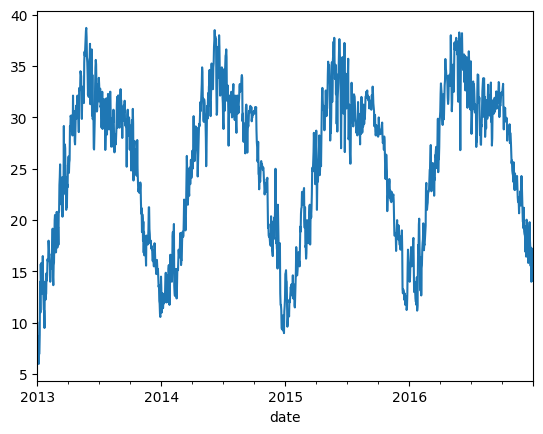

In [1410]:
train_df["meantemp"].plot()

<AxesSubplot: xlabel='date'>

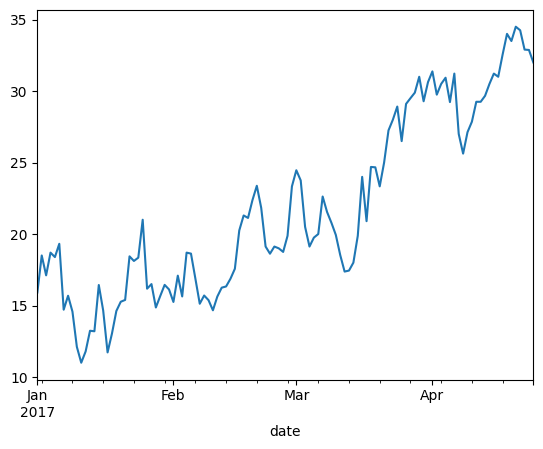

In [1411]:
test_df["meantemp"].plot()

Pada kasus time series, penggunaan scaling dapat meningkatkan performa model serta mempercepat waktu komputasi, oleh karena itu kita akan menggunakan `StandardScaler` dari sklearn yang melakukan scaling berdasarkan nilai z-score.

In [1412]:
from sklearn.preprocessing import StandardScaler

In [1413]:
# membuat object scaler
scaler = StandardScaler()

# melakukan scaling terhadap data train
train_scale = scaler.fit_transform(train_df)

# melakukan scaling terhadap data test
test_scale = scaler.transform(test_df)

In [1414]:
train_scale

array([[-2.1134429 ],
       [-2.46781583],
       [-2.49961853],
       ...,
       [-1.39950477],
       [-1.55527309],
       [-1.42478296]])

PyTorch membutuhkan data dalam bentuk tensor untuk dimasukkan ke dalam model, selain itu untuk kasus ini kita membutuhkan data dengan tipe float. Selain itu untuk proses selanjutnya, kita perlu membentuk data ke tensor 1D.

In [1415]:
import torch

In [1416]:
# merubah data ke bentuk tensor lalu reshape ke bentuk view(-1)
train_tensor = torch.FloatTensor(train_scale).view(-1)
test_tensor = torch.FloatTensor(test_scale).view(-1)

In [1417]:
train_tensor

tensor([-2.1134, -2.4678, -2.4996,  ..., -1.3995, -1.5553, -1.4248])

In [1418]:
train_tensor[:20]

tensor([-2.1134, -2.4678, -2.4996, -2.2952, -2.6586, -2.5223, -2.5223, -2.2692,
        -1.5683, -1.9771, -1.3346, -1.5683, -1.3184, -1.7273, -1.4709, -1.5910,
        -1.2275, -1.5910, -1.7727, -1.9382])

#### Dataset
Karena RNN memanfaatkan informasi sequential dari data kita, kita perlu memecah bentuknya menjadi kelompok-kelompok data. Hal ini akan kita lakukan menggunakan fungsi custom di bawah ini. 

In [1419]:
# function for making sequential data
def input_data(data, seq_size):
    out = []
    length = len(data)
    
    for i in range(length-seq_size):
        feature = data[i : i+seq_size]
        target = data[i+seq_size : i+seq_size+1]
        out.append((feature, target))
    
    return out

In [1420]:
# sebagai input di fungsi input_data
seq_size = 12

# apply fungsi custom ke data train dan test
train_dataset = input_data(train_tensor, seq_size)
test_dataset = input_data(test_tensor, seq_size)

In [1421]:
train_dataset[:2]

[(tensor([-2.1134, -2.4678, -2.4996, -2.2952, -2.6586, -2.5223, -2.5223, -2.2692,
          -1.5683, -1.9771, -1.3346, -1.5683]),
  tensor([-1.3184])),
 (tensor([-2.4678, -2.4996, -2.2952, -2.6586, -2.5223, -2.5223, -2.2692, -1.5683,
          -1.9771, -1.3346, -1.5683, -1.3184]),
  tensor([-1.7273]))]

In [1422]:
len(train_dataset)

1449

In [1423]:
len(test_dataset)

102

#### Dataloader

Dari proses di atas, kita telah membuat data dengan bentuk feature dan label/target secara berpasangan. Data ini akan kita jadikan bentuk DataLoader yang nantinya akan menjadi input dari model PyTorch kita. Pada kasus ini ada beberapa parameter DataLoader yang harus kita tentukan:
- dataset: data yang sudah diproses sebelumnya, dapat juga berupa PyTorch Dataset
- batch_size: ukuran minibatch yang ingin digunakan
- shuffle: pastikan bernilai **False** karena kasus time series

In [1424]:
from torch.utils.data import DataLoader

In [1425]:
# setting batch size
bs = 9

# buat DataLoader untuk data train dan test
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

In [1426]:
train_loader.dataset[0]

(tensor([-2.1134, -2.4678, -2.4996, -2.2952, -2.6586, -2.5223, -2.5223, -2.2692,
         -1.5683, -1.9771, -1.3346, -1.5683]),
 tensor([-1.3184]))

### Pembuatan Arsitektur

Data yang akan digunakan pada model sudah selesai dibentuk, sekarang saatnya kita membangun arsitektur pada RNN yang akan digunakan. Pada bagian ini kita akan membangun class dengan nama RNN yang isinya mengambil beberapa informasi dari module yang disediakan PyTorch. Module ini dapat diakses melalui `nn.Module`. Oleh karena itu kita panggil `nn` dahulu menggunakan syntax di bawah ini.

<!-- Pada class yang kita gunakan, terdapat 1 buah parameter bernama `num_layers`. Seperti namanya, num_layers disini menentukan jumlah hidden layers pada RNN cell kita. Untuk lebih lengkapnya berikut ilustrasi dari hidden layers pada RNN.

<img src="https://static.packt-cdn.com/products/9781787121089/graphics/image_06_008.png" width="80%"> 

Jika kita menggunakan num_layers > 1 dan tidak menentukan ukuran dari hidden_size maka secara otomatis PyTorch akan menggunakan hidden_size yang sama untuk seluruh layer kita. Tetapi jika kita ingin menentukan hidden_size yang berbeda, berikut diskusi mengenai cara pembentukan arsitekturnya: [link diskusi](https://discuss.pytorch.org/t/putting-different-hidden-size-for-multi-layer-lstm/47846) 
-->

<!--
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size, 
                          hidden_size=hidden_size, 
                          num_layers=num_layers) # RNN block (input ke hidden)
        self.fc = nn.Linear(hidden_size, output_size) # fully connected (hidden ke output)
        
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden
-->

In [1427]:
from torch import nn

Kita akan menggunakan skema seperti pada gambar di sebelah kanan, dimana terdapat layer input dan hidden (pada PyTorch keduanya sudah dirangkum oleh RNN block) serta output layer.
<img src="assets/nn_vs_rnn.png" width = "70%">

In [1428]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super().__init__()
        self.rnn = nn.RNN(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers
        ) # RNN block
        self.fc = nn.Linear(
            in_features = hidden_size,
            out_features = output_size
        ) # fully connected layer
        
    def forward(self, x, hidden): # langkah feedforward
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        
        return x, hidden

### Persiapan training

Dari class yang sudah dibentuk, terdapat beberapa input yang harus dimasukkan. Agar input terdokumentasi dengan baik maka sebaiknya kita simpan konfigurasinya ke dalam sebuah dictionary.

In [1429]:
seq_size

12

In [1430]:
config = {
    "input_size": seq_size, 
    "output_size": 1, 
    "hidden_size": 512, 
    "num_layers": 2
}

Setelah menyiapkan konfigurasi, kita akan memasukkan setting yang sudah dilakukan ke dalam model.

In [1431]:
# kunci randomness awal
torch.manual_seed(2102)

# buat model dan masukan konfigurasi
model = RNN(
    input_size = config["input_size"], 
    output_size = config["output_size"], 
    hidden_size = config["hidden_size"], 
    num_layers = config["num_layers"]
)

Sifat model RNN sama seperti model Neural Network biasa, yaitu setelah model melakukan feedforward maka perlu dihitung loss-nya. Pada bagian ini kita akan menentukan perhitungan loss yang digunakan adalah `MSELoss()` dari `nn` yang merupakan perhitungan **Mean Squared Error** karena data target kita berupa angka. Dokumentasi lengkap terkait loss function pada PyTorch dapat dilihat melalui [link ini](https://pytorch.org/docs/stable/nn.html#loss-functions).

In [1432]:
criterion = nn.MSELoss()

Setelah menentukan loss function yang digunakan, kita akan melakukan setting backpropagation dengan metode Stochastic Gradient Descent yang merupakan lanjutan dari metode Gradient Descent normal. Method untuk melakukkan setting ini terdapat pada module `optim` dari `torch`. Untuk mengakses optimizer Stochastic Gradient Descent kita akan menggunakan `optim.SGD()` dimana paramter yang perlu dimasukkan yaitu:
- `params`: parameter pada model, lebih mudahnya kita tinggal menuliskan `model.parameters()` yaitu mengambil nilai yang sudah kita siapkan di atas
- `lr`: learning rate

In [1433]:
from torch import optim

In [1434]:
optimizer = optim.SGD(params = model.parameters(), lr = 0.022)

In [1435]:
model.parameters

<bound method Module.parameters of RNN(
  (rnn): RNN(12, 512, num_layers=2)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)>

### Training and Evaluation Loop

Jika dilihat pada proses pembuatan model, kita tidak menentukan epoch atau jumlah iterasi yang kita inginkan padahal kasus Neural Network bergantung pada jumlah iterasi. Hal ini karena pada PyTorch kita harus menentukan sendiri fungsi looping untuk proses training maupun evaluasinya.

<!--
epochs = 100
train_cost, test_cost = [], []

for i in range(epochs):
    # code for training
    model.train() # set model ke train mode
    cost = 0 # inisialisasi perhitungan cost
    
    for feature, target in train_loader:
        output, hidden = model(feature, None) # feedforward
        loss = criterion(output, target) # hitung loss per per feedforward (MSE)
        loss.backward() # backpropagation
        
        optimizer.step() # update weight
        optimizer.zero_grad() # reset optimizer (khusus pytorch)

        # perhitungan loss total per minibatch (dikali jumlah data agar bisa dibagi dengan total data di akhir)
        cost += loss.item() * feature.shape[0] 
        # .item() buat ambil skalar nilai 
    train_cost.append(cost / len(train_data)) # cost (MSE) per epoch dicatat
    
    # code for evaluation
    with torch.no_grad(): # memastikan tidak terjadi perhitungan gradient
        model.eval() # set model ke evaluation mode
        cost = 0 # inisialisasi perhitungan cost
        for feature, target in test_loader:
            output, hidden = model(feature, None) # feedforward
            loss = criterion(output, target) # hitung loss per feedforward

            # data test ga backpropagation dan update weight nanti leakage

            # perhitungan loss total per minibatch (dikali jumlah data agar bisa dibagi dengan rata2)
            cost += loss.item() * feature.shape[0]
        test_cost.append(cost / len(test_data)) # cost (MSE) per epoch dicatat
    
    print(f'\rEpoch: {i+1}/{epochs} | train_cost: {train_cost[-1]:4f} | test_cost: {test_cost[-1]:4f}', end=' ')
-->

In [1436]:
train_loader.dataset[0]

(tensor([-2.1134, -2.4678, -2.4996, -2.2952, -2.6586, -2.5223, -2.5223, -2.2692,
         -1.5683, -1.9771, -1.3346, -1.5683]),
 tensor([-1.3184]))

In [1437]:
device = "gpu" if torch.cuda.is_available() else "cpu"

In [1438]:
device

'cpu'

In [1439]:
epochs = 30
train_cost, test_cost = [], []

for i in range(epochs):
    # training
    model.train()
    cost = 0
    for feature, target in train_loader: # iterasi untuk minibatch
        # feedforward
        output, hidden = model.forward(feature, None)
        # hitung loss
        loss = criterion(output, target)
        # backpropagation
        loss.backward()
        # update weight
        optimizer.step()
        # reset optimizer (kasus khusus pada pytorch)
        optimizer.zero_grad()
        
        # perhitungan loss total per minibatch (dikali jumlah data agar bisa dibagi dengan total data di akhir)
        cost += loss.item() * feature.shape[0] 
        # .item() buat ambil skalar nilai 
    train_cost.append(cost / len(train_dataset)) # cost (MSE) per epoch dicatat
    
    # evaluasi
    with torch.no_grad(): # memastikan tidak terjadi perhitungan gradient
        model.eval()
        cost = 0
        for feature, target in test_loader:
            # feedforward
            output, hidden = model.forward(feature, None)
            # hitung loss sebagai pembanding
            loss = criterion(output, target)
            # data test ga backpropagation dan update weight nanti leakage
            
            # perhitungan loss total per minibatch (dikali jumlah data agar bisa dibagi dengan rata2)
            cost += loss.item() * feature.shape[0]
        test_cost.append(cost / len(test_dataset)) # cost (MSE) per epoch dicatat

    print(f'\rEpoch: {i+1}/{epochs} | train_cost: {train_cost[-1]:4f} | test_cost: {test_cost[-1]:4f}', end=' ')

Epoch: 30/30 | train_cost: 0.048697 | test_cost: 0.058347 

Setelah training selesai, kita dapat melihat hasil evaluasi dengan melakukan plot loss data train dengan data test.

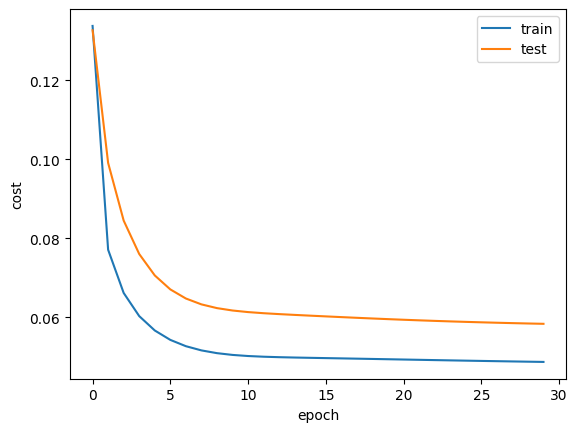

In [1440]:
plt.plot(train_cost, label = "train")
plt.plot(test_cost, label = "test")

plt.xlabel("epoch")
plt.ylabel("cost")
plt.legend()

### Prediction/Forecast

Dari hasil training, kita akan melakukan prediksi untuk waktu yang akan datang.

<!-- 
preds, targets = [], []
hidden = None
last_inputs = None

month = ___ # jumlah bulan yang akan diprediksi

with torch.no_grad():
    model.eval() 
    for inputs, target in test_loader: 
        output, hidden = model(inputs, hidden)
        preds += output.flatten().tolist()
        targets += target.flatten().tolist()
        last_inputs = inputs

    n_forecast = int(np.ceil(month/len(last_inputs))) # karena menggunakan minibatch, maka jumlah iterasi menyesuaikan

    for i in range(int(n_forecast)):
        # take last prediction result for new input
        pred_inputs = (last_inputs[-1][1:]).tolist()
        pred_inputs.append(preds[-1])
        
        # create new input format for models
        forecast_inputs = last_inputs[1:].tolist()
        forecast_inputs.append(pred_inputs)
        forecast_inputs = torch.tensor(forecast_inputs)
        
        # forecast and saving the result
        output, hidden = model(forecast_inputs, hidden)
        last_inputs = forecast_inputs
        preds += output.flatten().tolist()

# inverse the result since we use scaling on our data
preds = scaler.inverse_transform(pd.DataFrame(preds))
targets = scaler.inverse_transform(pd.DataFrame(targets)) 
-->

<!-- 
# Plot the predicted and actual values
plt.figure(figsize=(15,5))
plt.plot(targets, label='Actual')
plt.plot(preds, label='Predicted')

plt.axvline(len(test_dataset), color='k', linestyle="--", linewidth=1)
plt.axvline(len(test_dataset) + n_forecast*len(last_inputs), color='k', linestyle="--", linewidth=1)

plt.legend()
plt.show()
 -->

In [1441]:
preds, targets = [], []
hidden = None
last_inputs = None

month = 48 # jumlah bulan yang akan diprediksi

with torch.no_grad():
    model.eval() 
    for inputs, target in test_loader: 
        output, hidden = model(inputs, hidden)
        preds += output.flatten().tolist()
        targets += target.flatten().tolist()
        last_inputs = inputs

    n_forecast = int(np.ceil(month/len(last_inputs))) # karena menggunakan minibatch, maka jumlah iterasi menyesuaikan

    for i in range(int(n_forecast)):
        # take last prediction result for new input
        pred_inputs = (last_inputs[-1][1:]).tolist()
        pred_inputs.append(preds[-1])
        
        # create new input format for models
        forecast_inputs = last_inputs[1:].tolist()
        forecast_inputs.append(pred_inputs)
        forecast_inputs = torch.tensor(forecast_inputs)
        
        # forecast and saving the result
        output, hidden = model(forecast_inputs, hidden)
        last_inputs = forecast_inputs
        preds += output.flatten().tolist()

# inverse the result since we use scaling on our data
preds = scaler.inverse_transform(pd.DataFrame(preds))
targets = scaler.inverse_transform(pd.DataFrame(targets))

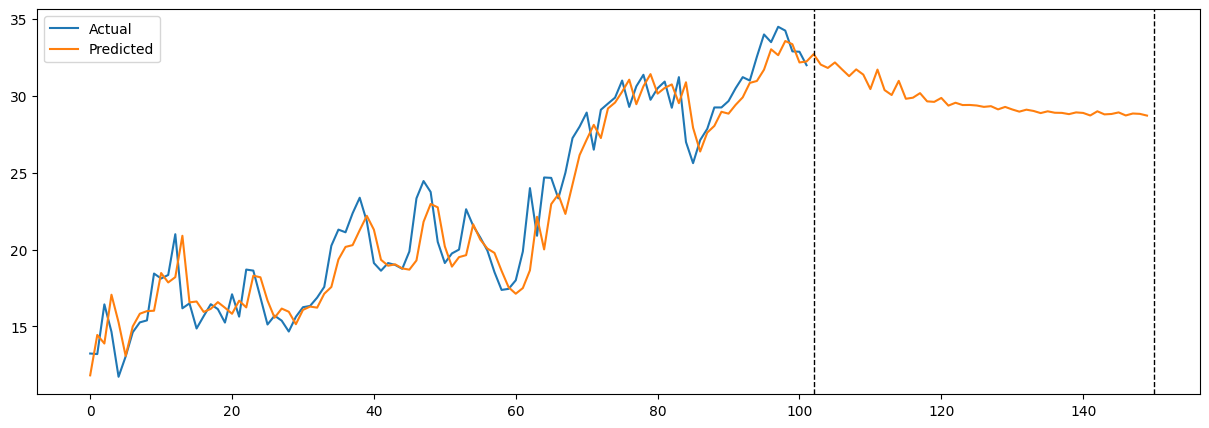

In [1442]:
# Plot the predicted and actual values
plt.figure(figsize=(15,5))
plt.plot(targets, label='Actual')
plt.plot(preds, label='Predicted')

plt.axvline(len(test_dataset), color='k', linestyle="--", linewidth=1)
plt.axvline(len(test_dataset) + n_forecast*len(last_inputs), color='k', linestyle="--", linewidth=1)

plt.legend()
plt.show()

### Save Model

Pada model deep learning, informasi yang akan disimpan ke dalam model adalah weight dari hidden layer pada epoch terakhir. Informasi weight ini dapat dilihat menggunakan method `.state_dict()` pada model kita. Setelah itu kita save menggunakan `torch.save()`.

In [1443]:
model.state_dict()

OrderedDict([('rnn.weight_ih_l0',
              tensor([[ 0.0161,  0.0327, -0.0058,  ...,  0.0368,  0.0248, -0.0249],
                      [ 0.0137,  0.0405,  0.0198,  ...,  0.0161,  0.0404, -0.0463],
                      [-0.0124,  0.0251, -0.0463,  ...,  0.0323,  0.0102,  0.0810],
                      ...,
                      [ 0.0036,  0.0272, -0.0315,  ..., -0.0195, -0.0408,  0.0043],
                      [ 0.0200, -0.0554, -0.0416,  ..., -0.0597, -0.0187, -0.1183],
                      [ 0.0279,  0.0035,  0.0431,  ..., -0.0012, -0.0165, -0.0195]])),
             ('rnn.weight_hh_l0',
              tensor([[ 0.0321, -0.0031, -0.0370,  ...,  0.0423, -0.0031, -0.0428],
                      [ 0.0084,  0.0037, -0.0028,  ...,  0.0215, -0.0308,  0.0140],
                      [ 0.0257, -0.0332, -0.0206,  ..., -0.0395,  0.0104, -0.0267],
                      ...,
                      [ 0.0236,  0.0359,  0.0309,  ..., -0.0448, -0.0003,  0.0263],
                      [-0.0263,  0.

In [1444]:
import os
os.makedirs("model", exist_ok=True) # membuat folder model

In [1445]:
torch.save(model.state_dict(), "model/rnn_weight.pth")

Selain weight, informasi yang biasa disimpan adalah configuration dari model kita. Sama seperti sebelumnya kita bisa menggunakan `torch.save()` untuk variable `config`.

In [1446]:
torch.save(config, "model/rnn_config.pth")

In [1447]:
config

{'input_size': 12, 'output_size': 1, 'hidden_size': 512, 'num_layers': 2}

### Load Model

Pada bagian ini kita akan melakukan load model yang sudah disimpan tadi. Sebagai catatan, load model dapat dilakukan asalkan arsitektur model kita buat serupa.

In [1448]:
# ambil arsitektur yang telah dibuat
class RNN_Load(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super().__init__()
        self.rnn = nn.RNN(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers
        ) # RNN block
        self.fc = nn.Linear(
            in_features = hidden_size,
            out_features = output_size
        ) # fully connected layer
        
    def forward(self, x, hidden): # langkah feedforward
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        
        return x, hidden

Load configuration serta weight dari file dapat menggunakan `torch.load()` lalu kita simpan ke dalam sebuah variable.

In [1449]:
config_load = torch.load("model/rnn_config.pth")
weight_load = torch.load("model/rnn_weight.pth")

In [1450]:
config_load

{'input_size': 12, 'output_size': 1, 'hidden_size': 512, 'num_layers': 2}

Load configuration kita masukkan secara manual, yaitu dengan mengambil value pada dictionary di object `weight_load`. Sementara untuk load weight, kita dapat menggunakan method `.load_state_dict()` pada model kita.

In [1451]:
model_2 = RNN_Load(
    input_size = config_load["input_size"], 
    output_size = config_load["output_size"], 
    hidden_size = config_load["hidden_size"], 
    num_layers = config_load["num_layers"]    
)

In [1452]:
model_2.load_state_dict(weight_load)

<All keys matched successfully>

In [1453]:
preds, targets = [], []
hidden = None
last_inputs = None

month = 48 # jumlah bulan yang akan diprediksi

with torch.no_grad():
    model_2.eval() 
    for inputs, target in test_loader: 
        output, hidden = model_2(inputs, hidden)
        preds += output.flatten().tolist()
        targets += target.flatten().tolist()
        last_inputs = inputs

    n_forecast = int(np.ceil(month/len(last_inputs))) # karena menggunakan minibatch, maka jumlah iterasi menyesuaikan

    for i in range(int(n_forecast)):
        # take last prediction result for new input
        pred_inputs = (last_inputs[-1][1:]).tolist()
        pred_inputs.append(preds[-1])
        
        # create new input format for models
        forecast_inputs = last_inputs[1:].tolist()
        forecast_inputs.append(pred_inputs)
        forecast_inputs = torch.tensor(forecast_inputs)
        
        # forecast and saving the result
        output, hidden = model_2(forecast_inputs, hidden)
        last_inputs = forecast_inputs
        preds += output.flatten().tolist()

# inverse the result since we use scaling on our data
preds = scaler.inverse_transform(pd.DataFrame(preds))
targets = scaler.inverse_transform(pd.DataFrame(targets))

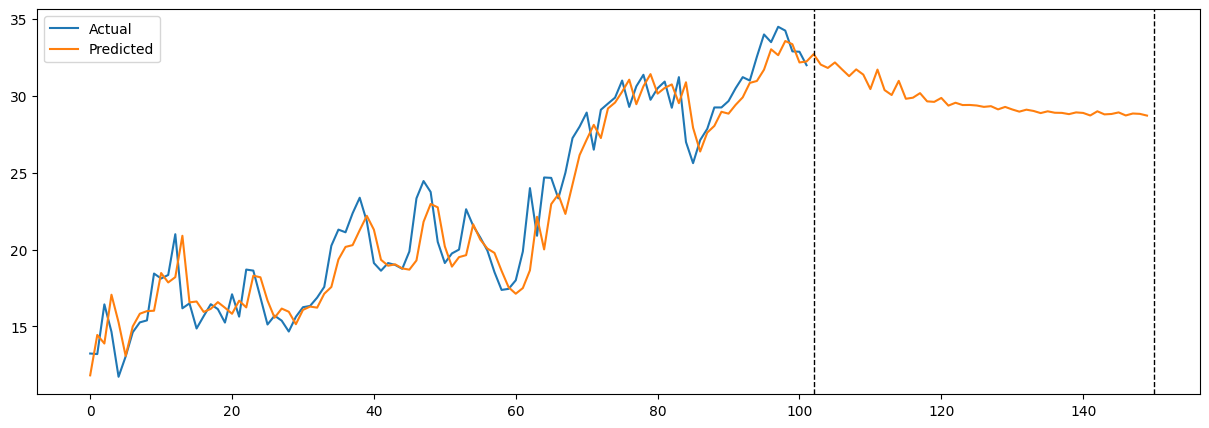

In [1454]:
# Plot the predicted and actual values
plt.figure(figsize=(15,5))
plt.plot(targets, label='Actual')
plt.plot(preds, label='Predicted')

plt.axvline(len(test_dataset), color='k', linestyle="--", linewidth=1)
plt.axvline(len(test_dataset) + n_forecast*len(last_inputs), color='k', linestyle="--", linewidth=1)

plt.legend()
plt.show()

## Penutup

Pada kasus forecasting ini beberapa kali dilakukan tuning untuk mendapatkan model yang optimal. Kasus ini menggunakan:
- Learning rate = 0.022
- Epoch = 30
- hidden_size = 512
- num_layer = 2

Hasilnya dirasa cukup optimal